# Food_KNN_and_RandomForest_Classification

1. Загрузка набора данных

(источник оригинального набора: https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/methods-and-application-of-food-composition-laboratory/mafcl-site-pages/sr11-sr28/, SR28ABXL.Zip (2.9 MB)-Excel file format).

2. Исследование содержимого набора данных: проверка на информативность столбцов и наличие зависимостей  
3. Подготовка данных для классификации методом K-ближайших соседей:
   - Обработка категориальных признаков и пропусков  
   - Выделение целевого признака `CLASS`  
   - Разделение на обучающую и тестовую выборки  
4. Обучение классификатора `KNeighborsClassifier` на обучающем наборе  
5. Применение модели к тестовой выборке и оценка результатов с помощью визуализации и метрик  
6. Нормализация данных двумя способами (`StandardScaler` и `MinMaxScaler`)  
7. Обучение моделей на нормализованных данных и сравнение результатов с исходной моделью  
8. Подбор гиперпараметров (кол-во соседей, метрика расстояния) с использованием `GridSearchCV`  
9. Оценка KNN-классификатора
10. Предварительный отбор признаков и оценка влияния на качество классификации:
    - Отбор одного признака из каждой группы сильно коррелирующих  
    - Объединение связанных по смыслу признаков (например, по витаминам)  
    - Повторный случайный отбор признаков (например, по 5 или 7 признаков, 100 повторений)  
    - Применение методов уменьшения размерности (например, PCA)  
    - Другие варианты отбора и подготовки признаков  

11. RandomForestClassifier

## Импорт библиотек


In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector

from google.colab import drive

In [2]:
warnings.filterwarnings("ignore")

## 1. Загрузка датасета

In [3]:
df = pd.read_excel('/content/ABBREV_with_CLASS.xlsx')

In [4]:
df.head()

,Unnamed: 0,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),...,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct,CLASS
0,0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,...,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0,10
1,1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,...,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0,10
2,2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,...,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0,0
3,3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,...,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0,10
4,4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,...,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0,10


Датасет содержит данные по всем продуктам питания, но не по всем питательным веществам - крахмал, фтор, бетаин, витамины D2 и D3, добавленный витамин Е, добавленный витамин В12, алкоголь, кофеин, теобромин, фитостеролы, отдельные аминокислоты, отдельные жирные кислоты или отдельные сахара не включены.  Эти данные приведены в расчете на 100 граммов съедобной порции.  Также предоставляется до двух домашних мер, что позволяет пользователю при желании рассчитать значения для каждой домашней меры.

In [5]:
df.columns

Index(['Unnamed: 0', 'NDB_No', 'Shrt_Desc', 'Water_(g)', 'Energ_Kcal',
       'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)', 'Carbohydrt_(g)',
       'Fiber_TD_(g)', 'Sugar_Tot_(g)', 'Calcium_(mg)', 'Iron_(mg)',
       'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)', 'Sodium_(mg)',
       'Zinc_(mg)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)',
       'Vit_C_(mg)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)',
       'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)',
       'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)',
       'Vit_B12_(µg)', 'Vit_A_IU', 'Vit_A_RAE', 'Retinol_(µg)',
       'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)',
       'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU',
       'Vit_K_(µg)', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'GmWt_Desc1', 'GmWt_2', 'GmWt_Desc2',
       'Refuse_Pct', 'CLASS'],
      dtype='object')

## 2. Исследование содержимого набора данных: проверка на информативность столбцов и наличие зависимостей  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         8790 non-null   int64  
 1   NDB_No             8790 non-null   int64  
 2   Shrt_Desc          8790 non-null   object 
 3   Water_(g)          8789 non-null   float64
 4   Energ_Kcal         8790 non-null   int64  
 5   Protein_(g)        8790 non-null   float64
 6   Lipid_Tot_(g)      8790 non-null   float64
 7   Ash_(g)            8465 non-null   float64
 8   Carbohydrt_(g)     8790 non-null   float64
 9   Fiber_TD_(g)       8196 non-null   float64
 10  Sugar_Tot_(g)      6958 non-null   float64
 11  Calcium_(mg)       8442 non-null   float64
 12  Iron_(mg)          8646 non-null   float64
 13  Magnesium_(mg)     8051 non-null   float64
 14  Phosphorus_(mg)    8211 non-null   float64
 15  Potassium_(mg)     8364 non-null   float64
 16  Sodium_(mg)        8707 

NDB_No – идентификационный номер продукта в базе данных.

Shrt_Desc – краткое описание продукта.

Water_(g) – содержание воды (г).

Energ_Kcal – энергетическая ценность (ккал).

Protein_(g) – содержание белков (г).

Lipid_Tot_(g) – общее количество жиров (г).

Ash_(g) – зольность (г).

Carbohydrt_(g) – содержание углеводов (г).

Fiber_TD_(g) – пищевые волокна (г).

Sugar_Tot_(g) – общее содержание сахаров (г).

Calcium_(mg) – содержание кальция (мг).

Iron_(mg) – содержание железа (мг).

Magnesium_(mg) – содержание магния (мг).

Phosphorus_(mg) – содержание фосфора (мг).

Potassium_(mg) – содержание калия (мг).

Sodium_(mg) – содержание натрия (мг).

Zinc_(mg) – содержание цинка (мг).

Copper_mg) – содержание меди (мг) (ошибка в названии столбца — скобка лишняя).

Manganese_(mg) – содержание марганца (мг).

Selenium_(µg) – содержание селена (мкг).

Vit_C_(mg) – содержание витамина C (мг).

Thiamin_(mg) – содержание тиамина (витамин B1) (мг).

Riboflavin_(mg) – содержание рибофлавина (витамин B2) (мг).

Niacin_(mg) – содержание ниацина (витамин B3) (мг).

Panto_Acid_(mg) – содержание пантотеновой кислоты (витамин B5) (мг).

Vit_B6_(mg) – содержание витамина B6 (мг).

Folate_Tot_(µg) – общее содержание фолатов (мкг).

Folic_Acid_(µg) – содержание фолиевой кислоты (мкг).

Food_Folate_(µg) – содержание пищевых фолатов (мкг).

Folate_DFE_(µg) – фолатный эквивалент диетического потребления (мкг).

Choline_Tot_(mg) – содержание холина (мг).

Vit_B12_(µg) – содержание витамина B12 (мкг).

Vit_A_IU – содержание витамина A в международных единицах (IU).

Vit_A_RAE – содержание витамина A в ретинол-эквивалентах (мкг).

Retinol_(µg) – содержание ретинола (мкг).

Alpha_Carot_(µg) – содержание альфа-каротина (мкг).

Beta_Carot_(µg) – содержание бета-каротина (мкг).

Beta_Crypt_(µg) – содержание бета-криптоксантина (мкг).

Lycopene_(µg) – содержание ликопина (мкг).

Lut+Zea_(µg) – содержание лютеина и зеаксантина (мкг).

Vit_E_(mg) – содержание витамина E (мг).

Vit_D_µg – содержание витамина D (мкг).

Vit_D_IU – содержание витамина D в международных единицах (IU).

Vit_K_(µg) – содержание витамина K (мкг).

FA_Sat_(g) – количество насыщенных жирных кислот (г).

FA_Mono_(g) – количество мононенасыщенных жирных кислот (г).

FA_Poly_(g) – количество полиненасыщенных жирных кислот (г).

Cholestrl_(mg) – содержание холестерина (мг).

GmWt_1 – вес первой стандартной порции (г).

GmWt_Desc1 – описание первой стандартной порции.

GmWt_2 – вес второй стандартной порции (г).

GmWt_Desc2 – описание второй стандартной порции.

Refuse_Pct – процент несъедобной части продукта.

CLASS – класс продукта.

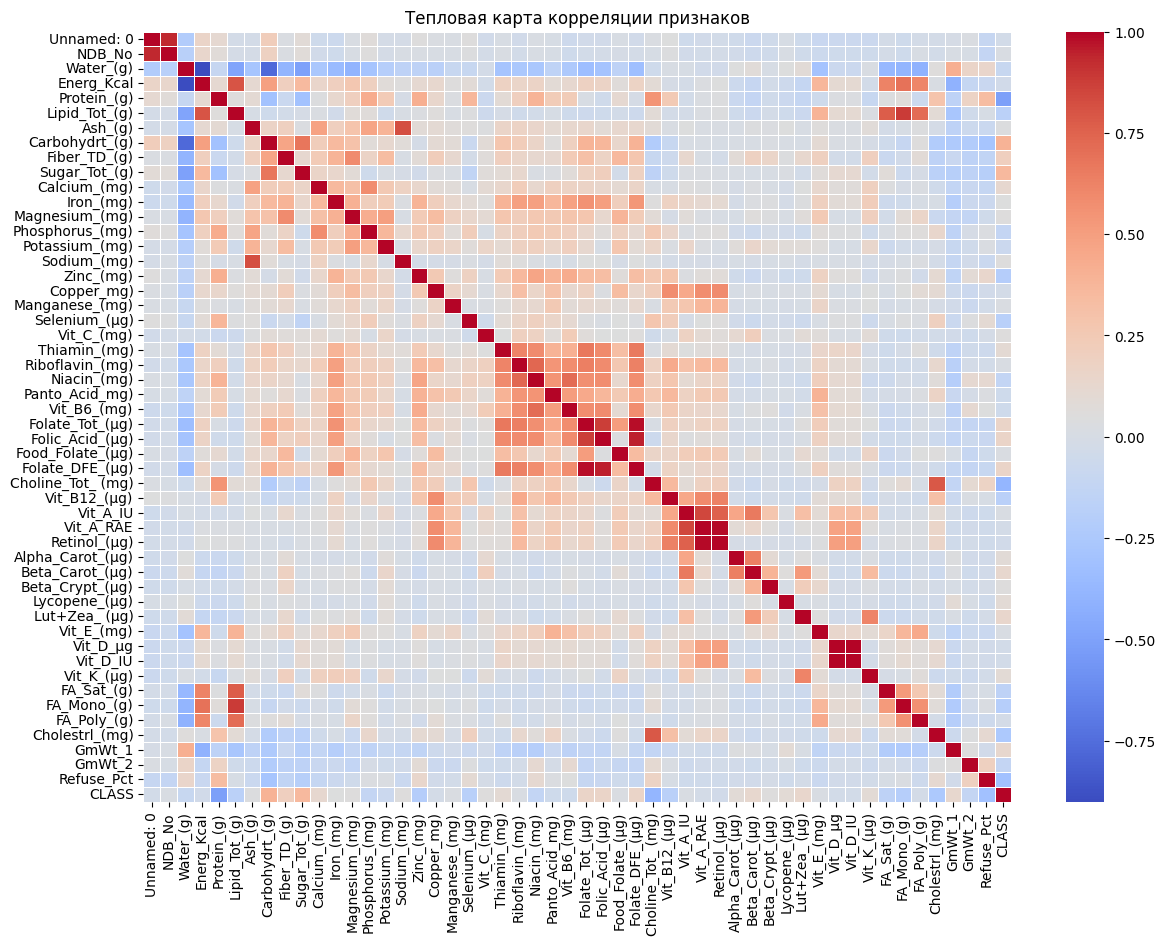

In [7]:
num_df = df.select_dtypes(include=["number"])

# Вычисляем корреляцию
corr_matrix = num_df.corr()

# Строим красивую тепловую карту
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    # annot=False,  # Можно True, но если много столбцов, будет перегружено
    cmap="coolwarm",
    linewidths=0.5,
    # mask=np.triu(corr_matrix)  # Оставляем только нижний треугольник
)
plt.title("Тепловая карта корреляции признаков")
plt.show()

## 3. Подготовка данных для классификации методом

In [8]:
df.head(-5)

,Unnamed: 0,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),...,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct,CLASS
0,0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,...,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0,10
1,1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,...,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0,10
2,2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,...,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0,0
3,3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,...,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0,10
4,4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,...,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8780,8780,44258,"PUDDINGS,CHOC FLAVOR,LO CAL,REG,DRY MIX",6.80,365,10.08,3.00,5.70,74.42,10.1,...,1.578,1.150,0.130,0.0,9.90,1 serving,40.0,1 package,0.0,10
8781,8781,44259,"PUDDINGS,ALL FLAVORS XCPT CHOC,LO CAL,REG,DRY MIX",10.40,351,1.60,0.10,1.86,86.04,0.9,...,0.018,0.032,0.050,0.0,113.00,1 serving,260.0,1 cup,0.0,10
8782,8782,44260,"PUDDINGS,ALL FLAVORS XCPT CHOC,LO CAL,INST,DRY...",6.84,350,0.81,0.90,6.80,84.66,0.8,...,0.099,0.116,0.433,0.0,8.00,1 serving,32.0,"1 package, 4 servings",0.0,10
8783,8783,48052,VITAL WHEAT GLUTEN,8.20,370,75.16,1.85,1.00,13.79,0.6,...,0.272,0.156,0.810,0.0,NaN,NaN,NaN,NaN,0.0,0


### Удаление столбцов

In [9]:
df.columns

Index(['Unnamed: 0', 'NDB_No', 'Shrt_Desc', 'Water_(g)', 'Energ_Kcal',
       'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)', 'Carbohydrt_(g)',
       'Fiber_TD_(g)', 'Sugar_Tot_(g)', 'Calcium_(mg)', 'Iron_(mg)',
       'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)', 'Sodium_(mg)',
       'Zinc_(mg)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)',
       'Vit_C_(mg)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)',
       'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)',
       'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)',
       'Vit_B12_(µg)', 'Vit_A_IU', 'Vit_A_RAE', 'Retinol_(µg)',
       'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)',
       'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU',
       'Vit_K_(µg)', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'GmWt_Desc1', 'GmWt_2', 'GmWt_Desc2',
       'Refuse_Pct', 'CLASS'],
      dtype='object')

In [10]:
df.drop(["Unnamed: 0", 'NDB_No', "Shrt_Desc", 'GmWt_1',	"GmWt_Desc1",	"GmWt_2",	"GmWt_Desc2"], axis=1, inplace=True)

In [11]:
df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Refuse_Pct,CLASS
0,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0,0.0,10
1,16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0,0.0,10
2,0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0,0.0,0
3,42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0,0.0,10
4,41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0,0.0,10


In [12]:
rename_dict = {
    "Copper_mg)": "Copper_(mg)",
    "Panto_Acid_mg)": "Panto_Acid_(mg)",
    }

df.rename(columns=rename_dict, inplace=True)

In [13]:
df.replace(["", "-", "None", "null"], pd.NA, inplace=True)

### Удаление дубликатов

In [14]:
df.shape

(8790, 48)

In [15]:
df.drop_duplicates()
df.shape

(8790, 48)

### Проверка на пропуски

In [16]:
df.isna().sum()

,0
Water_(g),1
Energ_Kcal,0
Protein_(g),0
Lipid_Tot_(g),0
Ash_(g),325
Carbohydrt_(g),0
Fiber_TD_(g),594
Sugar_Tot_(g),1832
Calcium_(mg),348
Iron_(mg),144


### Удаление столбцов, где пропущено много значений (больше 20%)

In [17]:
df.shape

(8790, 48)

In [18]:
threshold = 0.8 * len(df)
df.dropna(thresh=threshold, axis=1, inplace=True)

In [19]:
df.shape

(8790, 31)

In [20]:
df.columns

Index(['Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)',
       'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Calcium_(mg)', 'Iron_(mg)',
       'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)', 'Sodium_(mg)',
       'Zinc_(mg)', 'Copper_(mg)', 'Selenium_(µg)', 'Vit_C_(mg)',
       'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)', 'Vit_B6_(mg)',
       'Folate_Tot_(µg)', 'Vit_B12_(µg)', 'Vit_A_IU', 'Vit_A_RAE',
       'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)', 'Cholestrl_(mg)',
       'Refuse_Pct', 'CLASS'],
      dtype='object')

In [21]:
df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),...,Folate_Tot_(µg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Refuse_Pct,CLASS
0,15.87,717,0.85,81.11,2.11,0.06,0.0,24.0,0.02,2.0,...,3.0,0.17,2499.0,684.0,51.368,21.021,3.043,215.0,0.0,10
1,16.72,718,0.49,78.30,1.62,2.87,0.0,23.0,0.05,1.0,...,4.0,0.07,2468.0,683.0,45.390,19.874,3.331,225.0,0.0,10
2,0.24,876,0.28,99.48,0.00,0.00,0.0,4.0,0.00,0.0,...,0.0,0.01,3069.0,840.0,61.924,28.732,3.694,256.0,0.0,0
3,42.41,353,21.40,28.74,5.11,2.34,0.0,528.0,0.31,23.0,...,36.0,1.22,721.0,198.0,18.669,7.778,0.800,75.0,0.0,10
4,41.11,371,23.24,29.68,3.18,2.79,0.0,674.0,0.43,24.0,...,20.0,1.26,1080.0,292.0,18.764,8.598,0.784,94.0,0.0,10


### Первичый анализ, выбросы

In [22]:
df.describe()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),...,Folate_Tot_(µg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Refuse_Pct,CLASS
count,8789.000000,8790.000000,8790.000000,8790.000000,8465.000000,8790.000000,8196.000000,8442.000000,8646.000000,8051.000000,...,7529.000000,7597.000000,8079.000000,7255.000000,8441.000000,8124.000000,8125.000000,8380.000000,8740.000000,8790.000000
mean,54.112218,226.317634,11.342849,10.553725,1.783468,22.127710,2.187445,76.738214,2.699674,35.295988,...,51.598220,1.392472,735.810744,111.726120,3.576334,4.081006,2.288767,40.613246,4.964416,5.715586
std,30.772854,169.877539,10.530474,15.814842,3.004609,27.270822,4.383138,203.527453,5.687560,57.416785,...,136.601781,4.566460,3848.009267,847.905482,6.518840,7.010760,5.215654,119.869371,12.088471,5.076376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.700000,91.000000,2.380000,0.950000,0.840000,0.050000,0.000000,10.000000,0.540000,12.000000,...,5.000000,0.000000,0.000000,0.000000,0.220000,0.235750,0.220000,0.000000,0.000000,0.000000
50%,63.080000,191.000000,8.000000,5.140000,1.200000,9.340000,0.700000,21.000000,1.380000,21.000000,...,12.000000,0.240000,32.000000,4.000000,1.592000,1.938500,0.696000,4.000000,0.000000,10.000000
75%,77.960000,337.000000,19.880000,13.720000,2.090000,34.910000,2.600000,69.000000,2.600000,30.000000,...,46.000000,1.610000,252.500000,33.000000,4.345000,5.115000,2.081000,67.000000,0.000000,10.000000
max,100.000000,902.000000,88.320000,100.000000,99.800000,100.000000,79.000000,7364.000000,123.600000,781.000000,...,3786.000000,98.890000,100000.000000,30000.000000,95.600000,83.689000,74.623000,3100.000000,81.000000,11.000000


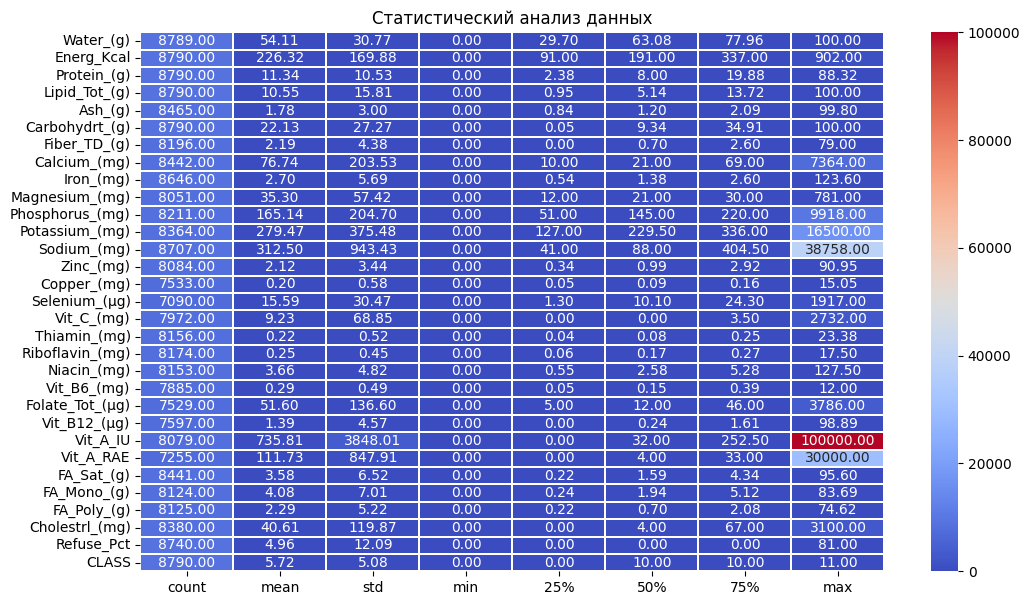

In [23]:
stats = df.describe().T  # Транспонируем для удобства

plt.figure(figsize=(12, 7))
sns.heatmap(stats, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.01)
plt.title("Статистический анализ данных")
plt.show()

### Заполнение пропусков

In [24]:
df.fillna(0, inplace=True)

In [25]:
df.isna().sum()

,0
Water_(g),0
Energ_Kcal,0
Protein_(g),0
Lipid_Tot_(g),0
Ash_(g),0
Carbohydrt_(g),0
Fiber_TD_(g),0
Calcium_(mg),0
Iron_(mg),0
Magnesium_(mg),0


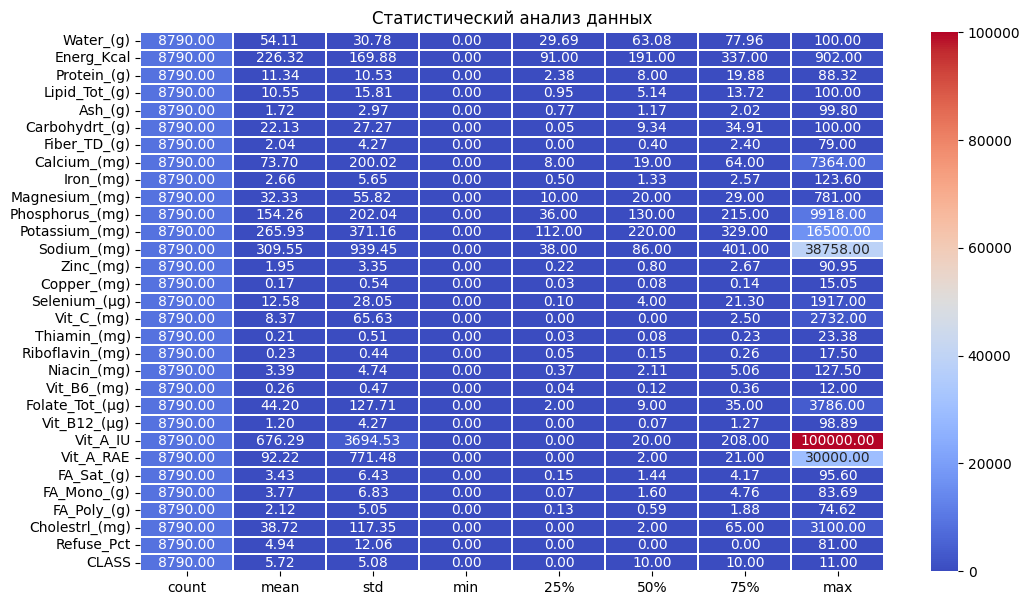

In [26]:
stats = df.describe().T  # Транспонируем для удобства

plt.figure(figsize=(12, 7))
sns.heatmap(stats, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.01)
plt.title("Статистический анализ данных")
plt.show()

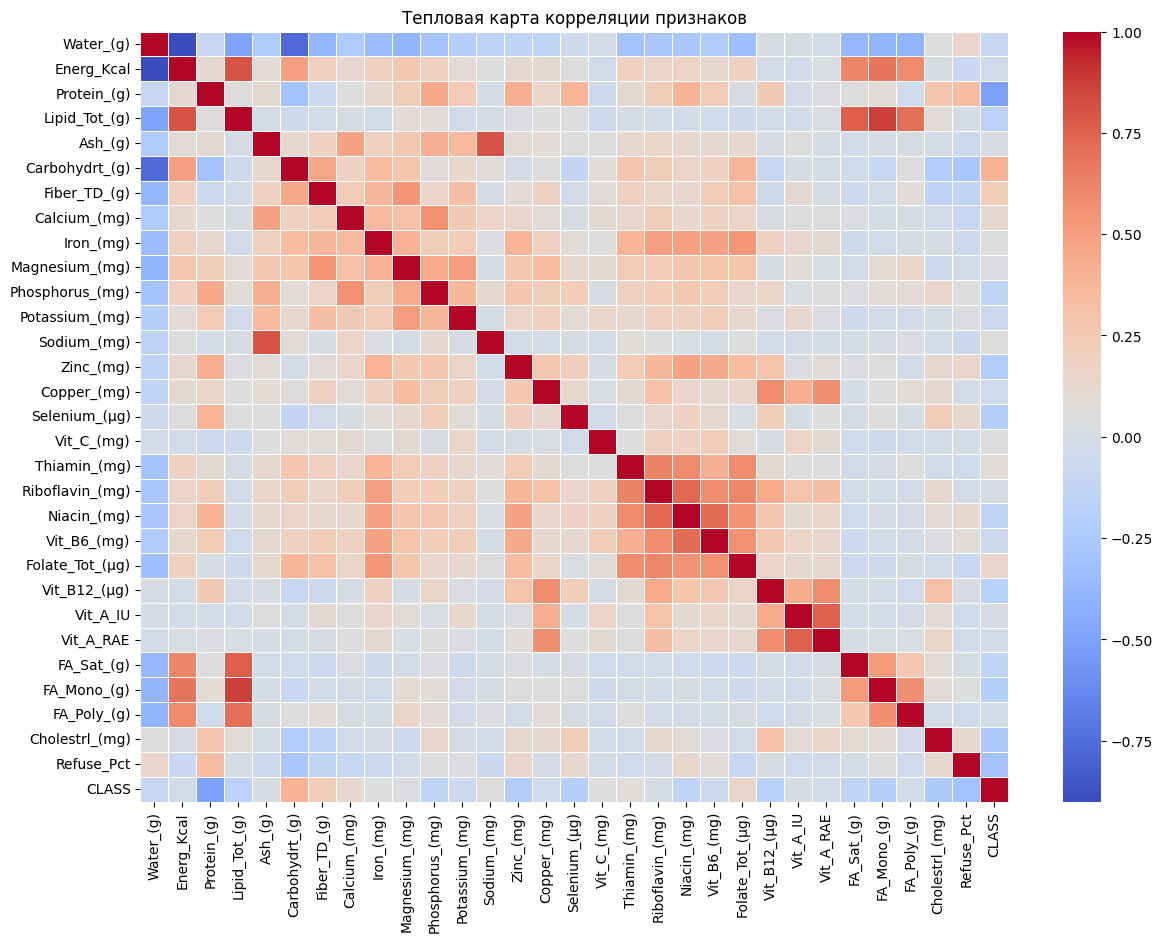

In [27]:
num_df = df.select_dtypes(include=["number"])

# Вычисляем корреляцию
corr_matrix = num_df.corr()

# Строим красивую тепловую карту
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    # annot=False,  # Можно True, но если много столбцов, будет перегружено
    cmap="coolwarm",
    linewidths=0.5,
    # mask=np.triu(corr_matrix)  # Оставляем только нижний треугольник
)
plt.title("Тепловая карта корреляции признаков")
plt.show()

### Удаление выбросов

#### Распределнение количественных признаков

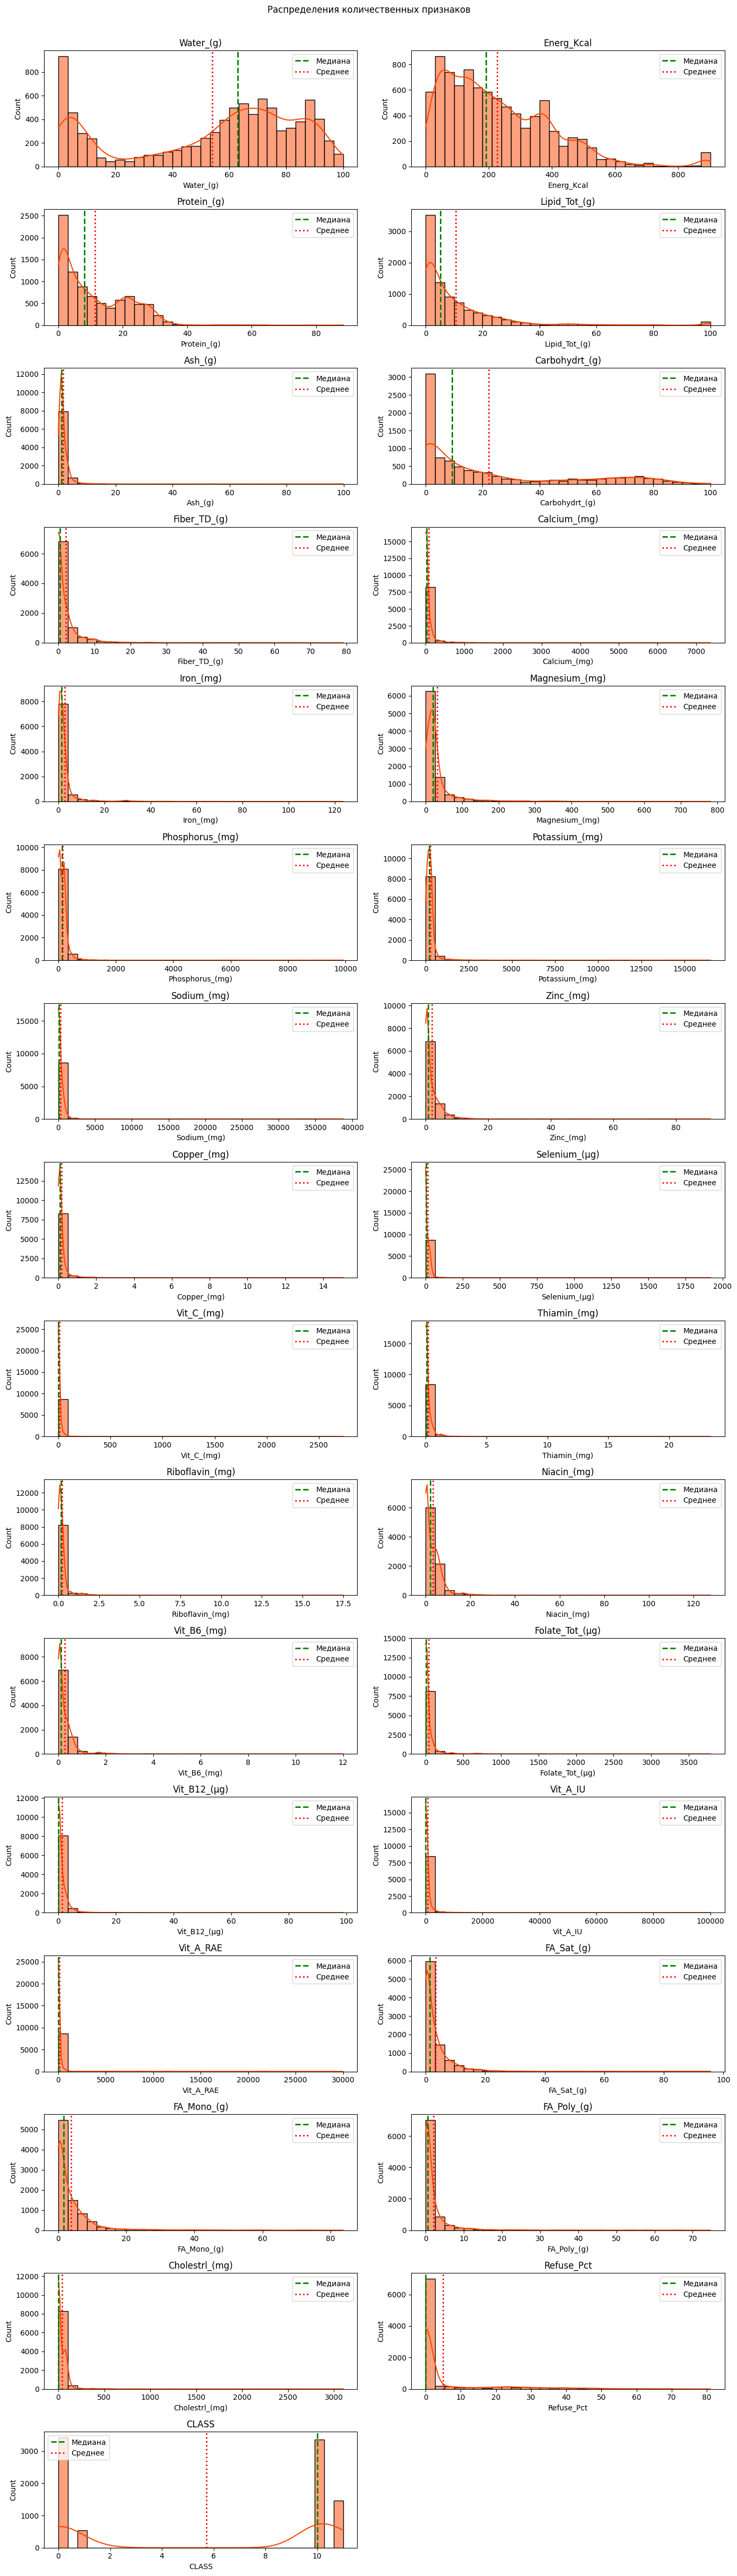

In [28]:
num_features = df.select_dtypes(include=['number']).columns
n = len(num_features)

fig, axes = plt.subplots(nrows=(n // 2) + (n % 2), ncols=2, figsize=(14, 3 * (n // 2 + n % 2)))

for ax, feature in zip(axes.flatten(), num_features):
    sns.histplot(df[feature], bins=30, kde=True, ax=ax, color="#FF4500")
    ax.set_title(feature)

    median_val = df[feature].median()
    mean_val = df[feature].mean()

    ax.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label="Медиана")
    ax.axvline(mean_val, color='red', linestyle='dotted', linewidth=2, label="Среднее")

    ax.set_title(feature)
    ax.legend()

for i in range(n, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.suptitle("Распределения количественных признаков", y=1.01)
plt.show()

#### Box-plot

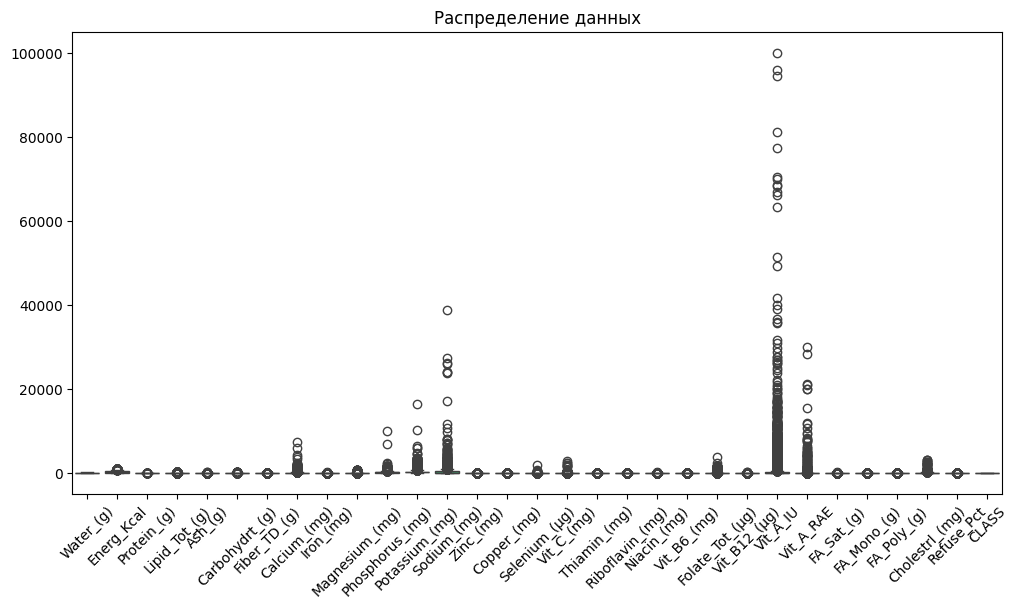

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)  # Поворот подписей
plt.title("Распределение данных")
plt.show()


#### Удаление выбросов

In [30]:
def remove_outliers_iqr(df, target_column="CLASS"):

    # Выбираем только числовые столбцы, исключая целевой
    numerical_features = df.select_dtypes(include=['number']).columns
    numerical_features = numerical_features.drop(target_column, errors='ignore')  # errors='ignore' if target_column is not numerical

    Q1 = df[numerical_features].quantile(0.25)  # 25-й перцентиль
    Q3 = df[numerical_features].quantile(0.75)  # 75-й перцентиль
    IQR = Q3 - Q1  # Межквартильный размах

    # Фильтруем выбросы (оставляем значения в пределах [Q1 - 1.5*IQR, Q3 + 1.5*IQR])
    # Применяем фильтр только к числовым столбцам, исключая целевой
    df_clean = df[~((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df_clean

In [31]:
def remove_outliers_zscore(df, threshold=3):
    z = np.abs((df - df.mean()) / df.std())
    df_clean = df[(z < threshold).all(axis=1)]
    return df_clean

In [32]:
df1 = remove_outliers_iqr(df)
df1.shape

(1911, 31)

In [33]:
df2 = remove_outliers_zscore(df)
df2.shape

(7311, 31)

In [34]:
df.shape

(8790, 31)

In [35]:
df = remove_outliers_zscore(df)

In [36]:
df.shape

(7311, 31)

### Отделение данных

In [37]:
X = df.drop(columns=["CLASS"])  # Убираем столбец с метками
y = df["CLASS"]  # Метки классов

### Разделение на тренировочные и тестовые данные

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4. Обучение классификатора KNeighborsClassifier

In [39]:
knn = KNeighborsClassifier()  # 5 соседей
knn.fit(X_train, y_train)

KNeighborsClassifier()

## 5. Применение модели к тестовой выборке и оценка результатов

### Предсказания на тестовых данных

In [40]:
y_pred = knn.predict(X_test)

### Оценка точности

In [41]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели KNN: {accuracy:.4f}")

Точность модели KNN: 0.7922


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       547
           1       0.48      0.40      0.44       103
          10       0.80      0.86      0.83       532
          11       0.74      0.81      0.77       281

    accuracy                           0.79      1463
   macro avg       0.72      0.71      0.72      1463
weighted avg       0.79      0.79      0.79      1463



### Матрица ошибок

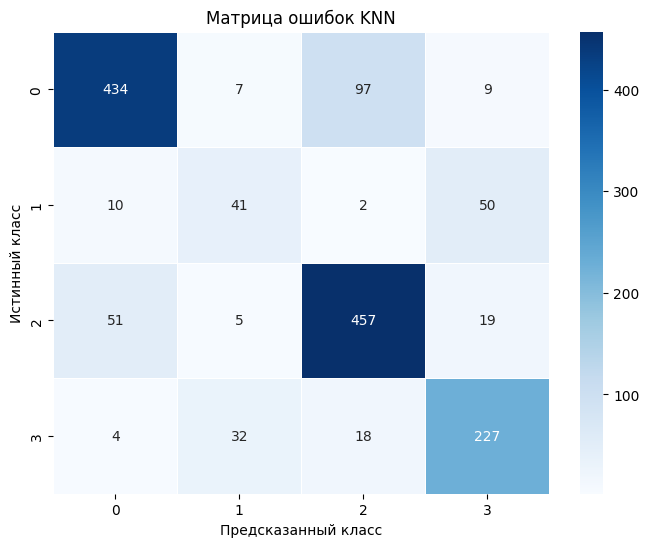

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок KNN")
plt.show()

Матрица ошибок KNN показывает, что модель в целом работает хорошо, но имеет проблемы с некоторыми классами. Класс 0 и класс 2 классифицируются относительно точно, однако класс 0 часто путается с классом 2, а класс 2 иногда ошибочно принимается за класс 0 или 3. Класс 3, напротив, имеет относительно высокую точность, но всё же часть его объектов ошибочно отнесена к другим классам.

## 6. Нормализация данных

In [44]:
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

### StandardScaler

In [45]:
scaler_standard = StandardScaler()

### MinMaxScaler

In [46]:
scaler_minmax = MinMaxScaler()

## 7. Обучение моделей на нормализованных данных и сравнение результатов с исходной моделью  

### StandardScaler

In [47]:
X_train_sc_std = scaler_standard.fit_transform(X_train_sc)
X_test_sc_std = scaler_standard.transform(X_test_sc)

knn_std = KNeighborsClassifier()
knn_std.fit(X_train_sc_std, y_train)

# Предсказания
y_pred_std = knn_std.predict(X_test_sc_std)

### MinMaxScaler

In [48]:
X_train_sc_mm = scaler_minmax.fit_transform(X_train_sc)
X_test_sc_mm = scaler_minmax.transform(X_test_sc)

knn_std = KNeighborsClassifier()
knn_std.fit(X_train_sc_mm, y_train)

# Предсказания
y_pred_mm = knn_std.predict(X_test_sc_mm)

### Оценка точности

In [49]:
# Оценка точности
accuracy_std = accuracy_score(y_test, y_pred_std)
accuracy_mm = accuracy_score(y_test, y_pred_mm)

### Сравнение

In [50]:
print(f"Точность KNN без нормализации: {accuracy:.4f}")
print(f"Точность KNN (StandardScaler): {accuracy_std:.4f}")
print(f"Точность KNN (MinMaxScaler): {accuracy_mm:.4f}")

Точность KNN без нормализации: 0.7922
Точность KNN (StandardScaler): 0.8319
Точность KNN (MinMaxScaler): 0.8530


### StandardScaler

In [51]:
print(classification_report(y_test, y_pred_std))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       547
           1       0.64      0.41      0.50       103
          10       0.83      0.88      0.85       532
          11       0.79      0.89      0.83       281

    accuracy                           0.83      1463
   macro avg       0.78      0.75      0.76      1463
weighted avg       0.83      0.83      0.83      1463



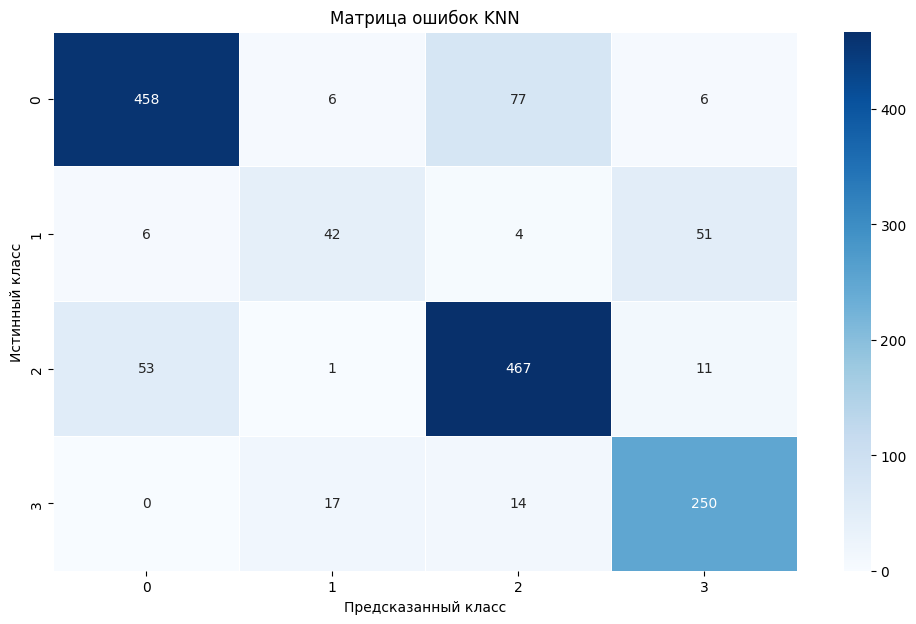

In [52]:
conf_matrix = confusion_matrix(y_test, y_pred_std)

plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок KNN")
plt.show()

### MinMaxScaler

In [53]:
print(classification_report(y_test, y_pred_mm))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       547
           1       0.68      0.48      0.56       103
          10       0.85      0.90      0.87       532
          11       0.82      0.92      0.86       281

    accuracy                           0.85      1463
   macro avg       0.81      0.78      0.79      1463
weighted avg       0.85      0.85      0.85      1463



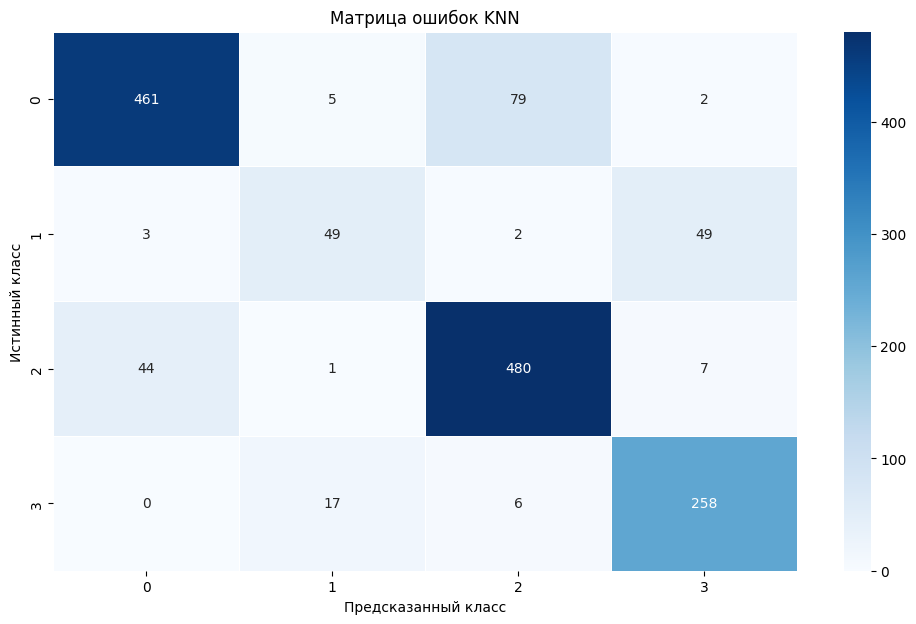

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred_mm)

plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок KNN")
plt.show()

### Вывод

Нормализация данных улучшила точность модели KNN по сравнению с использованием исходных данных. Метод MinMaxScaler показал наилучший результат, немного превосходя StandardScaler. Без нормализации точность была ниже, что подтверждает чувствительность KNN к масштабу признаков. Для данной модели рекомендуется использовать нормализацию, так как это положительно влияет на качество классификации.

## 8. Подбор гиперпараметров (кол-во соседей, метрика расстояния) с использованием `GridSearchCV`

In [55]:
param_grid = {
    'n_neighbors': range(2, 21),  # Количество соседей от 1 до 20
        'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine', 'hamming']  # Метрики расстояния
}

# Инициализируем модель
knn = KNeighborsClassifier()

# Инициализируем GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sc_mm, y_train)  # Обучаем на нормализованных данных

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 5}
Лучшая точность: 0.8397739319895008


### Обучение модели с оптимальными параметрами

In [56]:
best_knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
best_knn.fit(X_train_sc_mm, y_train)

# Делаем предсказания
y_pred_best = best_knn.predict(X_test_sc_mm)

### Оценка точности

In [57]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Точность модели KNN с оптимальными параметрами (MinMaxScaler): {accuracy_best:.4f}")

Точность модели KNN с оптимальными параметрами (MinMaxScaler): 0.8571


In [58]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       547
           1       0.71      0.49      0.58       103
          10       0.85      0.90      0.88       532
          11       0.82      0.93      0.87       281

    accuracy                           0.86      1463
   macro avg       0.82      0.79      0.80      1463
weighted avg       0.86      0.86      0.85      1463



### Матрица ошибок

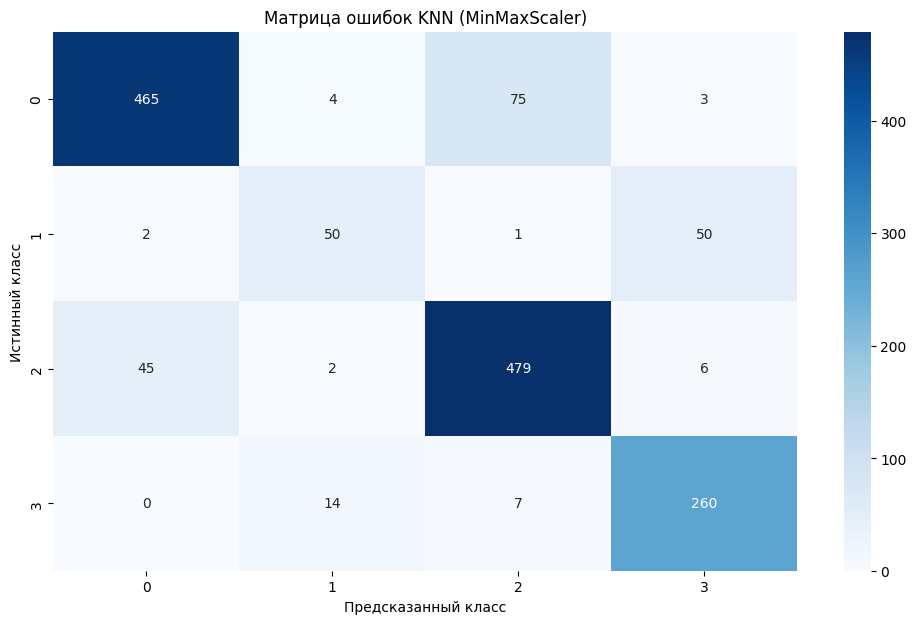

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок KNN (MinMaxScaler)")
plt.show()

## 9. Оценка KNN-классификатора

Метод k-ближайших соседей (KNN) прост в реализации, не требует предположений о распределении данных и хорошо работает с многоклассовой классификацией. Выбор метрики расстояния позволяет адаптировать модель.  

Основные недостатки – высокая вычислительная сложность, чувствительность к шуму и выбросам, зависимость от выбора k и необходимость нормализации данных.  

На данном датасете нормализация улучшила точность модели: Класс 1 классифицируется хуже из-за малого количества данных или схожести с другими классами.  

KNN подходит для небольших и средних наборов данных, но требует нормализации и подбора гиперпараметров.

## 10. Отбор признаков

### Оставим только по одному из сильно коррелирующих признаков

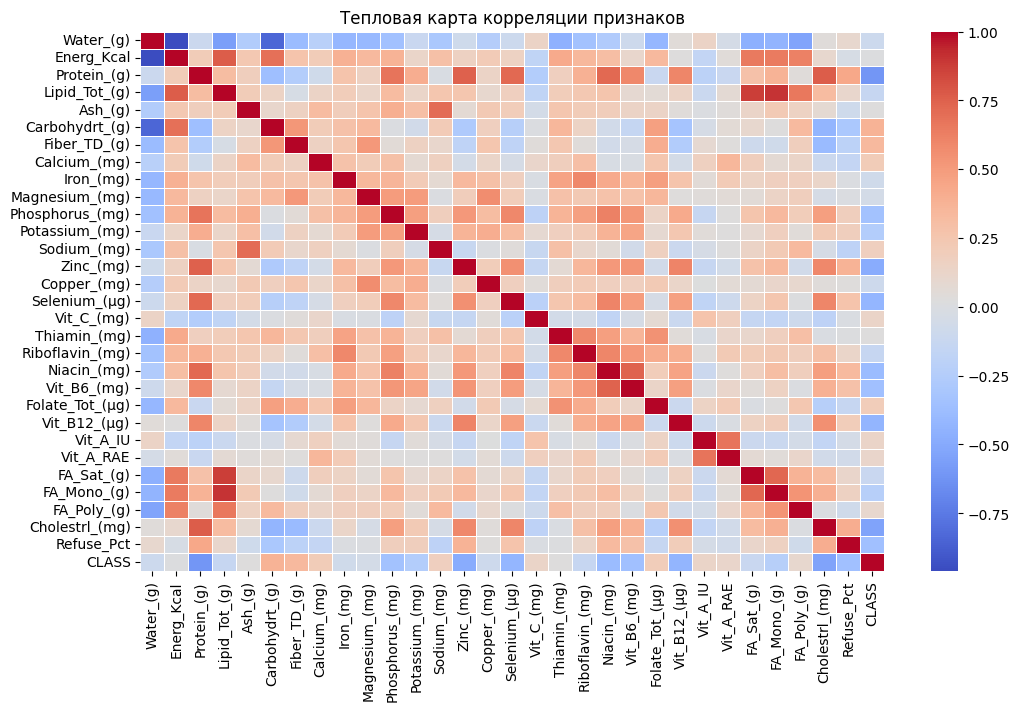

In [60]:
num_df = df.select_dtypes(include=["number"])

# Вычисляем корреляцию
corr_matrix = num_df.corr()

# Строим красивую тепловую карту
plt.figure(figsize=(12, 7))

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    linewidths=0.5,
)
plt.title("Тепловая карта корреляции признаков")
plt.show()

In [61]:
corr_matrix = df.corr().abs()  # Вычисляем матрицу корреляций по модулю
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Оставляем верхний треугольник

# Находим признаки с высокой корреляцией
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Удаляем их
df_reduced = df.drop(columns=to_drop)

In [62]:
X_reduced = df_reduced.drop(columns=["CLASS"])  # Убираем столбец с метками
y_reduced = df_reduced["CLASS"]  # Метки классов

In [63]:
# Разделяем данные на обучающую и тестовую выборки (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced)

# Создаём модель KNN с 5 соседями (по умолчанию)
knn = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
knn.fit(X_train, y_train)

# Делаем предсказания
y_pred = knn.predict(X_test)

In [64]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность KNN: {accuracy:.4f}")

Точность KNN: 0.7744


              precision    recall  f1-score   support

           0       0.89      0.79      0.84       547
           1       0.40      0.28      0.33       103
          10       0.79      0.83      0.81       532
          11       0.67      0.82      0.74       281

    accuracy                           0.77      1463
   macro avg       0.69      0.68      0.68      1463
weighted avg       0.78      0.77      0.77      1463



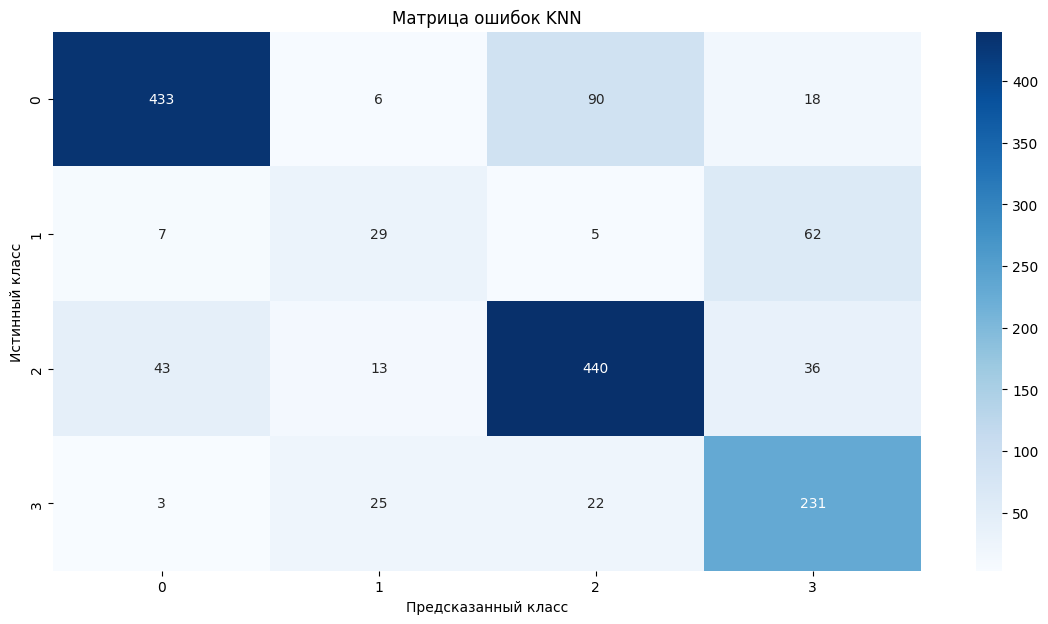

In [65]:
print(classification_report(y_test, y_pred))

# Строим матрицу ошибок
plt.figure(figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок KNN")
plt.show()

После удаления коррелирующих признаков точность модели снизилась, что указывает на то, что удаление признаков, возможно, привело к потере важной информации, необходимой для точного предсказания. Это может свидетельствовать о том, что некоторые коррелирующие признаки все же играют важную роль в модели.

### Объединим группу связанных по смыслу признаков в один

In [66]:
df_merge_vitamins = df.copy()

#### 1. Объединение признаков для витаминов

In [67]:
df_merge_vitamins["Vitamins"] = df_merge_vitamins[[
    "Vit_C_(mg)", "Thiamin_(mg)", "Riboflavin_(mg)", "Niacin_(mg)",
    "Vit_B6_(mg)", "Folate_Tot_(µg)", "Vit_B12_(µg)", "Vit_A_IU", "Vit_A_RAE"
]].sum(axis=1)

df_merge_vitamins.drop(columns=[
    "Vit_C_(mg)", "Thiamin_(mg)", "Riboflavin_(mg)", "Niacin_(mg)",
    "Vit_B6_(mg)", "Folate_Tot_(µg)", "Vit_B12_(µg)", "Vit_A_IU", "Vit_A_RAE"
], inplace=True)

X_vitamins = df_merge_vitamins.drop(columns=["CLASS"])
y_vitamins = df_merge_vitamins["CLASS"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_vitamins, y_vitamins, test_size=0.2, random_state=42, stratify=y_vitamins)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность KNN (Витамины): {accuracy:.4f}")

Точность KNN (Витамины): 0.8578


#### 2. Объединение признаков для жиров

In [70]:
df_merge_fat = df.copy()

In [71]:
df_merge_fat["Fats"] = df_merge_fat[["FA_Sat_(g)", "FA_Mono_(g)", "FA_Poly_(g)"]].sum(axis=1)

df_merge_fat.drop(columns=["FA_Sat_(g)", "FA_Mono_(g)", "FA_Poly_(g)"], inplace=True)

X_fats = df_merge_fat.drop(columns=["CLASS"])
y_fats = df_merge_fat["CLASS"]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_fats, y_fats, test_size=0.2, random_state=42, stratify=y_fats)
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [73]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность KNN (Жиры): {accuracy:.4f}")

Точность KNN (Жиры): 0.8640


#### 3.  Объединение признаков для минералов

In [74]:
df_merge_mineral = df.copy()

In [75]:
df_merge_mineral["Minerals"] = df_merge_mineral[[
    "Calcium_(mg)", "Iron_(mg)", "Magnesium_(mg)", "Phosphorus_(mg)",
    "Potassium_(mg)", "Sodium_(mg)", "Zinc_(mg)", "Copper_(mg)", "Selenium_(µg)"
]].sum(axis=1)

df_merge_mineral.drop(columns=[
    "Calcium_(mg)", "Iron_(mg)", "Magnesium_(mg)", "Phosphorus_(mg)",
    "Potassium_(mg)", "Sodium_(mg)", "Zinc_(mg)", "Copper_(mg)", "Selenium_(µg)"
], inplace=True)

X_minerals = df_merge_mineral.drop(columns=["CLASS"])
y_minerals = df_merge_mineral["CLASS"]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_minerals, y_minerals, test_size=0.2, random_state=42, stratify=y_minerals)
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [77]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность KNN (Минералы): {accuracy:.4f}")

Точность KNN (Минералы): 0.8612


#### 4. Для всего сразу

In [78]:
df_merge = df.copy()

In [79]:
df_merge["Vitamins"] = df_merge[[
    "Vit_C_(mg)", "Thiamin_(mg)", "Riboflavin_(mg)", "Niacin_(mg)",
    "Vit_B6_(mg)", "Folate_Tot_(µg)", "Vit_B12_(µg)", "Vit_A_IU", "Vit_A_RAE"
]].sum(axis=1)

df_merge["Fats"] = df_merge[["FA_Sat_(g)", "FA_Mono_(g)", "FA_Poly_(g)"]].sum(axis=1)
df_merge["Minerals"] = df_merge[[
    "Calcium_(mg)", "Iron_(mg)", "Magnesium_(mg)", "Phosphorus_(mg)",
    "Potassium_(mg)", "Sodium_(mg)", "Zinc_(mg)", "Copper_(mg)", "Selenium_(µg)"
]].sum(axis=1)

df_merge.drop(columns=[
    "Vit_C_(mg)", "Thiamin_(mg)", "Riboflavin_(mg)", "Niacin_(mg)",
    "Vit_B6_(mg)", "Folate_Tot_(µg)", "Vit_B12_(µg)", "Vit_A_IU", "Vit_A_RAE",
    "FA_Sat_(g)", "FA_Mono_(g)", "FA_Poly_(g)",
    "Calcium_(mg)", "Iron_(mg)", "Magnesium_(mg)", "Phosphorus_(mg)",
    "Potassium_(mg)", "Sodium_(mg)", "Zinc_(mg)", "Copper_(mg)", "Selenium_(µg)"
], inplace=True)

In [80]:
X_reduced = df_merge.drop(columns=["CLASS"])
y_reduced = df_merge["CLASS"]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced)

In [81]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [82]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность KNN (Все группы): {accuracy:.4f}")

Точность KNN (Все группы): 0.8578


Наилучшую точность показала модель, использующая жиры, немного опередив модель с витаминами.
Модель, основанная на микроэлементах, показала немного более низкую точность
Объединение всех групп признаков дало меньшую точность

Объединение признаков не привело к улучшению модели, а наоборот, снизило точность.

### Повторно выберем случайным образом поднабор из нескольких признаков и будем искать лучшую точность

In [83]:
# Количество повторений и выборок признаков
num_iterations = 100
num_features = 7  # Размер поднабора признаков

best_accuracy = 0
best_features = None

# Основной процесс выбора признаков и обучения модели
for _ in range(num_iterations):
    selected_features = random.sample(list(X_reduced.columns), num_features)

    X_subset = X_reduced[selected_features]
    y = y_reduced

    # Разделяем данные
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)

    # Масштабируем данные
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Обучаем KNN
    knn = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
    knn.fit(X_train, y_train)

    # Предсказания
    y_pred = knn.predict(X_test)

    # Оценка точности
    accuracy = accuracy_score(y_test, y_pred)

    # Запоминаем лучший результат
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = selected_features

print(f"Лучшая точность: {best_accuracy:.4f}")
print(f"Лучшие признаки: {best_features}")

Лучшая точность: 0.8626
Лучшие признаки: ['Lipid_Tot_(g)', 'Protein_(g)', 'Ash_(g)', 'Water_(g)', 'Cholestrl_(mg)', 'Energ_Kcal', 'Fiber_TD_(g)']


Лучшая точность при случайном выборе признаков оказалась близкой к результатам, полученным без объединения групп признаков. Это указывает на то, что случайный отбор признаков не привел к значительному улучшению модели по сравнению с более структурированными подходами.

### Используем методы уменьшения размерности

#### PCA

In [84]:
X = df.drop(columns=["CLASS"])
y = df["CLASS"]

In [85]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Применяем PCA для уменьшения размерности (сохраняем 95% дисперсии)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [86]:
knn = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
knn.fit(X_train, y_train)

# Предсказания
y_pred = knn.predict(X_test)

In [87]:
accuracy_pca = accuracy_score(y_test, y_pred)
print(f"Точность модели KNN после применения PCA: {accuracy_pca:.4f}")

Точность модели KNN после применения PCA: 0.8503


#### RFE

In [88]:
X = df.drop(columns=['CLASS'])  # все признаки, кроме целевой переменной
y = df['CLASS']  # целевая переменная

# Разделяем на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [89]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [90]:
# Используем RFE для отбора признаков
knn = KNeighborsClassifier()

selector = SequentialFeatureSelector(knn, n_features_to_select=10, direction='forward')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

### Рейтинг признаков (меньше — важнее)

In [91]:
selected_features = X.columns[selector.get_support()]
selected_features

Index(['Water_(g)', 'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Iron_(mg)',
       'Magnesium_(mg)', 'Phosphorus_(mg)', 'Copper_(mg)', 'Selenium_(µg)',
       'Thiamin_(mg)', 'Vit_B12_(µg)'],
      dtype='object')

#### Маска выбранных признаков

In [92]:
selector.support_

array([ True, False, False, False, False,  True,  True, False,  True,
        True,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False])

In [93]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [94]:
# Лучшие параметры и точность
print(f"Лучшие параметры: {grid_search.best_params_}")
best_knn = grid_search.best_estimator_

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [95]:
# Предсказания и оценка точности
y_pred = best_knn.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность KNN после оптимизации и отбора признаков: {accuracy:.4f}")

Точность KNN после оптимизации и отбора признаков: 0.8763


#### Модель с оптимальными параметрами после RFE

In [96]:
# Создание модели KNN с оптимальными параметрами
knn_optimal = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance')

# Обучаем модель на тренировочных данных
knn_optimal.fit(X_train_scaled, y_train)

# Делаем предсказания
y_pred_optimal = knn_optimal.predict(X_test_scaled)

In [97]:
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"Точность модели KNN с оптимальными параметрами: {accuracy_optimal:.4f}")

Точность модели KNN с оптимальными параметрами: 0.8694


In [98]:
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       547
           1       0.76      0.53      0.63       103
          10       0.86      0.92      0.89       532
          11       0.82      0.93      0.87       281

    accuracy                           0.87      1463
   macro avg       0.84      0.81      0.82      1463
weighted avg       0.87      0.87      0.87      1463



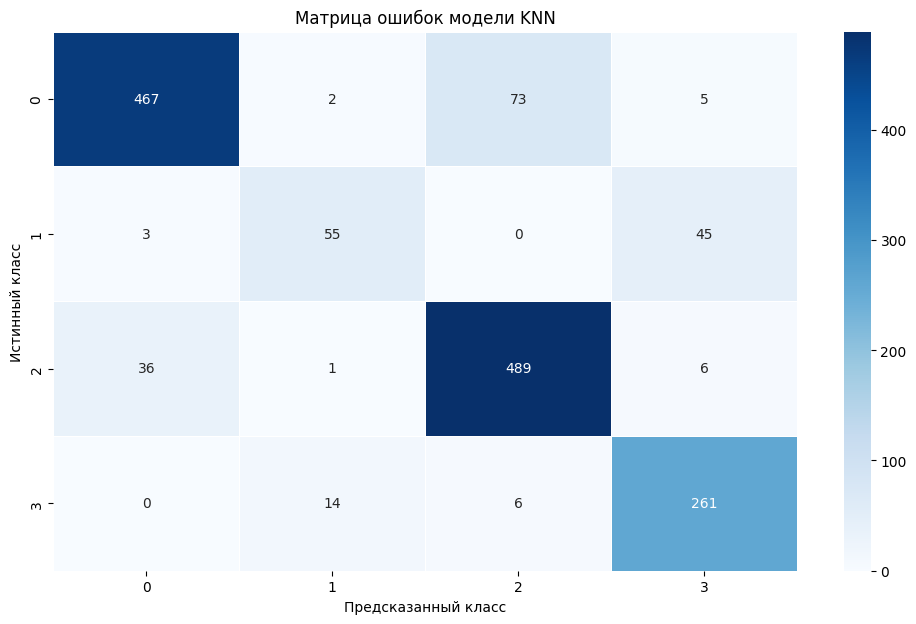

In [99]:
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок модели KNN")
plt.show()

Точность модели KNN с оптимальными параметрам значительно улучшилась по сравнению с предыдущими результатами. Это подтверждает, что правильный подбор гиперпараметров способен значительно улучшить точность модели KNN.

## 11. RandomForestClassifier

In [100]:
X = df.drop(columns=["CLASS"])  # Признаки
y = df["CLASS"]  # Целевая переменная

# Нормализация данных с использованием MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделяем данные на обучающую и тестовую выборки (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [101]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [102]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Точность Random Forest: {rf_accuracy:.4f}")

Точность Random Forest: 0.9029


In [103]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       547
           1       0.88      0.55      0.68       103
          10       0.88      0.97      0.92       532
          11       0.86      0.97      0.91       281

    accuracy                           0.90      1463
   macro avg       0.89      0.84      0.86      1463
weighted avg       0.91      0.90      0.90      1463



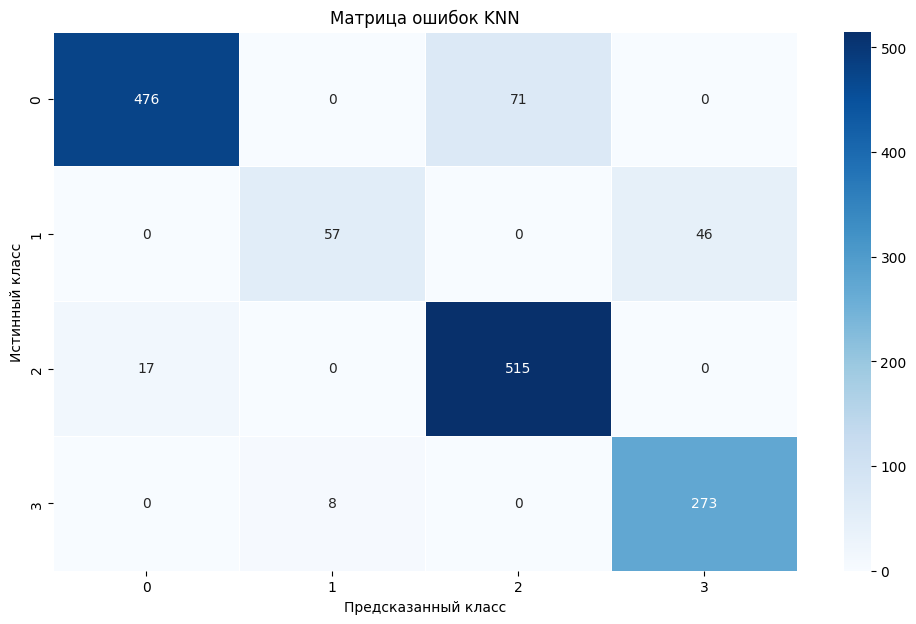

In [104]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок KNN")
plt.show()

Точность модели Random Forest: 0.9029 значительно улучшена по сравнению с предыдущими точностями.

Сравнив эти значения, можно сделать вывод, что Random Forest дает гораздо более высокую точность, что свидетельствовует о более эффективном обучении на этих данных по сравнению с KNN.